<div class="alert alert-danger"><strong> ANN

</strong></div>

|Code Symbol | Definition | Dimensions
| :-: | :-: | :-: |
|X|Input Data, each row in an example| (num_Samples, inputLayerSize)|
|y |target data|(num_Samples, outputLayerSize)|
|w | weights | (inputLayerSize, hiddenLayerSize) |
|b | biases | (inputLayerSize, inputLayerSize) |
|structure | ANN structure | (outputLayerSize, hiddenLayers...,inputLayerSize ) |
|activfunc | Used Activation functions | (num_layers) |
|outputfunc | Output Layer activation | (num_Samples, outputLayerSize) |
|differ_b | ∇biases in each iter | (num_nodes, 1) |
|differ_w | ∇weight in each iter | (prevlayerSize, weightsSize) |stopcrit_acc| A threshold to stop iteratoin | (float)
|stopcrit_acc |  A threshold to stop iteratoin | (float)


## Importing Libraries

In [56]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
!pip install colorama

In [26]:
from rutaul import pb,py,pg,pr



........... 🆂  🆃  🅰   🆁  🆃 ...........


In [28]:
from keras.datasets import mnist # It used to take the data from it 
import matplotlib.pyplot as plt
import numpy as np
import sys
import pdb
from sympy import Matrix, init_printing
init_printing()
import random
np.set_printoptions(precision=2)



## Loading and Printing some Samples 

11493376/11490434 [==============================] - 0s 0us/step


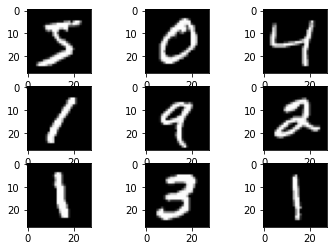

In [29]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
for i in range(9):  
    plt.subplot(331 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()


## $ Cost Function for Softmax: $ <center> C = $-\frac{1}{n}$$\sum\limits_{i=1}^{n}$$[y_i\log(\hat{y_i})+(1-{y_i})\log(1-\hat{y_i})]$ </center>

## Flatten and normilizing the matrix

In [30]:
def hot_one_converter(number,classificatoin_count=10):
    """ Takes a number and return a hot one array
    Hot one array: is an array of zeros and single one

    Args:
        number (int): number to be converted to array the number will represented as the only one in the array
        classificatoin_count (int, optional): Size of the array. Defaults to 10.
    """
    hot_one = np.zeros((classificatoin_count,1))
    #if number > -1 and number < classificatoin_count:
    hot_one[number] = 1
    return hot_one
def flatten_normalize_matrix(matrix):
    """It takes a matrix and return a matrix with one dimension and it normilize the elements to a value between 1 and 0
        * It does not handle negative value well    

    Args:
        matrix (ndarray): array to be normilized and flatten

    Returns:
        Array: one dimension array elements between 0 and 1
    """
    return np.reshape( matrix.flatten() /np.max(matrix) , (-1,1))

train_yv = [ hot_one_converter(res) for res in train_y]
train_Xv = [ flatten_normalize_matrix(res)  for res in train_X]

test_yv = [hot_one_converter(res) for res in test_y]
test_Xv = [flatten_normalize_matrix(res)for res in test_X]


# Creating the neural netword main class 

#### $$     Z_l(x) = ( w_{1} a_{1} + w_{2} a_{2} ... + w_{n} a_{n} ) + b   $$
#### $$ sigmoid =  \sigma(Z_l(x)) =  \frac{1}{1 +  e^{-x} } $$ 
#### $$    Softmax = \frac{\sigma(Z_l(x)) }{\sum_j \sigma(Z_l(x))        }        $$ 



In [31]:
class class_actifunc: 
    def __init__(self):
        self.flist  = {'sigmoid' : {'func': self.sigmoid,
                                   'dfunc': self.de_sigmoid
                                    },
                       'ReLU' : {'func': self.ReLU,
                                   'dfunc': self.de_ReLU
                                    },
                       'LeakyReLU': {'func': self.LeakyReLU,
                                   'dfunc': self.de_LeakyReLU
                                    },
                       'Tanh': {'func': self.tanh,
                                   'dfunc': self.de_tanh
                                    },
                       'ELU': {'func': self.ELU,
                                   'dfunc': self.de_ELU
                                    },
                       'softmax': {'func': self.softmax,
                                   'dfunc': self.de_softmax
                                    },
                       'MSE'    :  self.cost_derivative,
                       'c_entropy':  self.crossentropy,
                       'AMSE':  self.cost_abs,
                       
                   }
    # ----------------------- sofrmax --------------------------------
    def de_softmax(self,z,y_target):
      """ Derivative Softmax of vector function."""
      # pr(z.shape)
      jac = np.diagflat(z)
      
      for i in range(len(jac)):
          for j in range(len(jac)):
              if i == j:
                jac[i][j] = float(z[i] * (1-z[i]))
              else: 
                jac[i][j] = -z[i]*z[j]
      p = np.reshape(jac[np.argmax(y_target)],(-1,1))
      return p
          
    @staticmethod
    def softmax(z):
        """ Softmax of vector function."""
        exp=np.exp(z-np.max(z)) # to avoid reaching NaN in case one of the value is zero "it does not effect the outcome
        s = np.sum(exp)
        # py('z\n', z)
        # pb('for  \n',exp/s)
        return exp/s 
    # ----------------------- LeakyReLU --------------------------------     
    def de_LeakyReLU(self,z,_=0,alpha =.1):
        """Derivative of Leaky ReLU function."""
        return np.where(z > 0, 1.0, alpha)  
    @staticmethod
    def LeakyReLU(z,alpha =.1):
        """The Leaky ReLU function."""
        return np.maximum(alpha * z, z)        
    # ----------------------- ELU --------------------------------
    def de_ELU(self,z,_=0,alpha =.1):
        """Derivative of Leaky ReLU function."""
        return 1 if z > 0 else alpha*np.exp(z)
    @staticmethod
    def ELU(z,alpha =.1):
        """The Leaky ReLU function."""
        return z if z >= 0 else alpha*(e^z -1)
    # ----------------------- sigmoid --------------------------------
    def de_sigmoid(self,z,_=0):
        """ Derivative of the sigmoid function."""
        return self.sigmoid(z)*(1-self.sigmoid(z))   
    @staticmethod
    def sigmoid(z):
        """ sigmoid function."""
        # print(z)
        
        return 1.0/(1.0+np.exp(-z))
    # ----------------------- tanh --------------------------------
    def de_tanh(self,z,_=0):
        """Derivative of the Tanh function."""
        return 1 - np.power(self.tanh(z), 2)
    @staticmethod
    def tanh(z):
        """The Tanh function."""
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    # ----------------------- ReLU --------------------------------
    def de_ReLU(self,z,_=0):
        """Derivative of the ReLU function."""
        # pg(z)

        zz =[ .001 if x < 0 else 0 for x in z ]
        z[z<=0] = 0
        z[z>0] = .01
        # py('zz',zz)
        # pb('derelu', z )
        return z
    @staticmethod
    def ReLU(z):
        """The ReLU function."""
        # py('z',z)
        # pg('relu\n', np.maximum(0, z) )

        return np.maximum(0, z) 
#         return z * (z > 0)

    # ----------------------- Cost Functions  --------------------------------

    def cost_derivative(self, layer_output, y_target):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (layer_output-y_target)

    def cost_abs(self, layer_output, y_target):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return np.abs(layer_output-y_target)
    
    def crossentropy(self,  y_hat,y_target):
        c1 = -y_target * (np.log(y_hat + 1e-8))
        c2 = (1.-y_target)*np.log(1.-y_hat + 1e-8)
        cost = np.sum(c1-c2) 
        return cost
    

actf = class_actifunc()    


#['func'](7)

# act.fun['sigmoid']['defunc'](3)#['func'](7)
# activationfunc.sigmoid['func']



# Neural network class

In [32]:
class network:
    """
    Neural network class that creats a network with fixed size and has forword, backword methods 
    to adjust the weights and biases
    """
    def __init__(self, structure:list,activfunc=['sigmoid'],outputfunc='softmax',stopcrit_acc = .0001,costfunc='MSE',**kargs):
        """Intiating the network and creating weights and biases randomly 
         unless a set by **kargs where the __dict__ will be updated 

        Args:
             stopcrit_acc (float): The threshold where iteration will stop that is the different in accuracy between 
                                 last epoch and the current one
             structure (list): List of integer describing the layers neurons count
                                e.g. [3,4,4,2] 
             activfunc (list): List of activation function for each layer. ** It has a length of 
                                 n-2 as the output has outputfunc variable or length one and 
             outputfunc (activfun method): The output layer function e.g softmax
             costfunc   (costfunc method): The cost function
        """
        self.cost_tracker = []
        self.lambda_accuracy_stopcriterion = stopcrit_acc
        self.structure = structure
        self.cost = actf.flist[costfunc]
        self.activfunc = activfunc
        self.outputfunc = outputfunc
        # Creating normal random number around zero the 
        self.b = [np.random.randn(x, 1) for x in structure[1:]] # Biases 
        self.w = [np.random.randn(x2, x1) for x1, x2 in zip(structure[:-1], structure[1:])] # Weights
        
    
        if len(activfunc) ==1:
            self.activfunc = [activfunc[0]] * (len(structure)-1) 
        else :
           self.activfunc = activfunc

        self.__dict__.update(kargs)

        
        self.printonce= True
#         pdb.set_trace()

    def forward(self, inp):
        func = class_actifunc()

        i = 1 # a varible to apply the soft max function if it was giving 
        number_layers = len(self.structure)
        for f, b, w in zip(self.activfunc, self.b, self.w):
          i+=1
          if i == number_layers: # to examined if the last layer is reached

            if self.outputfunc: # if the activation function is provided
              inp = func.flist[self.outputfunc]['func'](np.dot(w, inp)+b) 
            else:
              inp = func.flist[f]['func'](np.dot(w, inp)+b)
          
          else:
            inp = func.flist[f]['func'](np.dot(w, inp)+b) #  sigmoid(np.dot(w, data)+b)
#             pdb.set_trace()
        return inp
    
    

    def SGD(self, training_data, epochs, batch_size, lr,
            test_data=None):
        self.epochs = epochs
        self.lr = lr
        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
        
        previousacc = 0
        nettest.cost_tracker.append(previousacc)
        stop_epoch =False # this boolean is for stop criterion
        for i in range(epochs):
#             global stop_epoch
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+batch_size]
                for k in range(0, n, batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
                
                
           
            current_accuracy =  self.evaluate(test_data)/n_test
            stop_epoch = self.stop_criterion(previousacc,current_accuracy)
            previousacc = current_accuracy
            self.cost_tracker.append(previousacc)

            print(f"Iter No: {i} ==> Correct answers: {self.evaluate(test_data)} out of {n_test} Acc:{current_accuracy}");
      
            if stop_epoch:
                print('stop criterion difference in accuracy is smaller than value giving stopcrit_acc: ', self.lambda_accuracy_stopcriterion)
                break
                
    def stop_criterion(self,previousAccuracy,currentAccuracy):
        """ Check how much the current accuracy is different from the previous epoch accuracy and 
            return boolean value to determine whether to move forword or stop iteration
        """
        diff = currentAccuracy - previousAccuracy
        if diff < np.absolute(self.lambda_accuracy_stopcriterion):
            return True
        print('pass stop criterion test')
        return False
        
        
    def update_mini_batch(self, mini_batch, lr):
        # ------------ creating empty array -------------------
        differ_b = [np.zeros(b.shape) for b in self.b]
        differ_w = [np.zeros(w.shape) for w in self.w]
        # ------------------- Calling backprop ----------------
        for x, y in mini_batch:
            total_differ_b, total_differ_w = self.backprop(x, y)
            differ_b = [delta + dffb for delta, dffb in zip(differ_b, total_differ_b)]
            differ_w = [delta + dffw for delta, dffw in zip(differ_w, total_differ_w)]
        # --------------- updating the value -------------------
        self.w = [w - (lr/len(mini_batch)) * dw for w, dw in zip(self.w, differ_w)]
        self.b = [b - (lr/len(mini_batch)) * db for b, db in zip(self.b, differ_b)]



    def backprop(self, x, y):
        func = class_actifunc()
        
        differ_b = [np.zeros(b.shape) for b in self.b]
        differ_w = [np.zeros(w.shape) for w in self.w]
        # -----------------------------------  Feedforward ------------------------------------
        a_layer_output = x
        
        layer_output = [x] # list to store all the layer_output, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.b, self.w):
            z = np.dot(w, layer_output[-1]) + b
            zs.append(z)

            a_layer_output = func.flist[self.activfunc[-1]]['func'](z)

            layer_output.append(a_layer_output)
            
         # =============================== END Feedforward END ============================
        

        # ------------------------    Backward Pass Output Layer     ----------------------
        differ = self.cost(layer_output[-1], y) * func.flist[self.activfunc[-1]]['dfunc'](zs[-1], y)
        differ_b[-1] = differ
        differ_w[-1] = np.dot(differ, layer_output[-2].transpose())
        
        # =====================  END  Backward Pass Output Layer END   ====================

        
        # ---------------------------       Backward Pass         -------------------------

        for lyr in range(2, len(self.structure)):
            z = zs[-lyr]
            sp = func.flist[self.activfunc[-lyr]]['dfunc'](z, y)
            differ = np.dot(self.w[-lyr+1].transpose(), differ) * sp
            differ_b[-lyr] = differ
            differ_w[-lyr] = np.dot(differ, layer_output[-lyr-1].transpose())
       # =====================  END  Backward Pass Output Layer END   ====================
        return (differ_b, differ_w)

    def evaluate(self, test_data):
      test_results = [(np.argmax(self.forward(x)), np.argmax(y)) for (x, y) in test_data]
      return  sum( [1  if x == y else 0 for (x, y) in test_results ])


In [33]:
nettest =network([784, 8,10],['sigmoid'],outputfunc='softmax', stopcrit_acc = .005,costfunc='MSE')

nettest.SGD(zip(train_Xv,train_yv),200, 10, .4 ,test_data=zip(test_Xv,test_yv))



pass stop criterion test
Iter No: 0 ==> Correct answers: 7214 out of 10000 Acc:0.7214
pass stop criterion test
Iter No: 1 ==> Correct answers: 8120 out of 10000 Acc:0.812
pass stop criterion test
Iter No: 2 ==> Correct answers: 8412 out of 10000 Acc:0.8412
pass stop criterion test
Iter No: 3 ==> Correct answers: 8570 out of 10000 Acc:0.857
Iter No: 4 ==> Correct answers: 8618 out of 10000 Acc:0.8618
stop criterion difference in accuracy is smaller than value giving stopcrit_acc:  0.005


In [36]:
nettest.activfunc 

['sigmoid', 'softmax']

# Trying the neural network with 784 input layer, 2 hidden layers with 16 nodes each, and 10 output nodes
The activation function used is the sigmiod function for all layers and no softmax function


In [39]:
nettest2 = network([784,16,16, 10],['sigmoid'], stopcrit_acc = .001,outputfunc='softmax',costfunc='MSE')
nettest2.SGD(zip(train_Xv,train_yv),20, 20, .3,test_data=zip(test_Xv,test_yv))


pass stop criterion test
Iter No: 0 ==> Correct answers: 1121 out of 10000 Acc:0.1121
Iter No: 1 ==> Correct answers: 1061 out of 10000 Acc:0.1061
stop criterion difference in accuracy is smaller than value giving stopcrit_acc:  0.001


In [40]:
nettest3 =network([784, 16,8,10],['sigmoid'],outputfunc='softmax', stopcrit_acc = .005,costfunc='MSE')

nettest3.SGD(zip(train_Xv,train_yv),200, 10, .4 ,test_data=zip(test_Xv,test_yv))


pass stop criterion test
Iter No: 0 ==> Correct answers: 7306 out of 10000 Acc:0.7306
pass stop criterion test
Iter No: 1 ==> Correct answers: 8342 out of 10000 Acc:0.8342
pass stop criterion test
Iter No: 2 ==> Correct answers: 8698 out of 10000 Acc:0.8698
pass stop criterion test
Iter No: 3 ==> Correct answers: 8875 out of 10000 Acc:0.8875
pass stop criterion test
Iter No: 4 ==> Correct answers: 8961 out of 10000 Acc:0.8961
Iter No: 5 ==> Correct answers: 8998 out of 10000 Acc:0.8998
stop criterion difference in accuracy is smaller than value giving stopcrit_acc:  0.005


# Let us try different structure ( 784,10,16,10 ) and let see its effect on the learning process With ReLU

It is absorvable that changing the structure changes the outcome but it will not allow for huge different in the result unless different technique is applied such edge filtering layer

In [50]:
nettestR = network([784,10,16, 10],['ReLU'], stopcrit_acc = .0005,outputfunc=False,costfunc='MSE')
nettestR.SGD(zip(train_Xv,train_yv),20, 10, .05,test_data=zip(test_Xv,test_yv))


pass stop criterion test
Iter No: 0 ==> Correct answers: 8474 out of 10000 Acc:0.8474
pass stop criterion test
Iter No: 1 ==> Correct answers: 8733 out of 10000 Acc:0.8733
pass stop criterion test
Iter No: 2 ==> Correct answers: 8780 out of 10000 Acc:0.878
pass stop criterion test
Iter No: 3 ==> Correct answers: 8887 out of 10000 Acc:0.8887
Iter No: 4 ==> Correct answers: 8765 out of 10000 Acc:0.8765
stop criterion difference in accuracy is smaller than value giving stopcrit_acc:  0.0005


In [ ]:
nettest =network([784,10,16, 10],['sigmoid'], stopcrit_acc = .0005,outputfunc=False,costfunc='MSE')
nettest.SGD(zip(train_Xv,train_yv),200, 10, .03,test_data=zip(test_Xv,test_y))


pass stop criterion test
Iter No: 0 ==> Correct answers: 857 out of 10000 Acc:0.0857
pass stop criterion test
Iter No: 1 ==> Correct answers: 1856 out of 10000 Acc:0.1856
Iter No: 2 ==> Correct answers: 1692 out of 10000 Acc:0.1692
stop criterion difference in accuracy is smaller than value giving stopcrit_acc:  0.0005


In [41]:
best_Structure =network([784,25,16, 10],['sigmoid'], stopcrit_acc = .00005,outputfunc=False,costfunc='MSE')

best_Structure.SGD(zip(train_Xv,train_yv),200, 10, .1,test_data=zip(test_Xv,test_yv))


pass stop criterion test
Iter No: 0 ==> Correct answers: 5379 out of 10000 Acc:0.5379
pass stop criterion test
Iter No: 1 ==> Correct answers: 7274 out of 10000 Acc:0.7274
pass stop criterion test
Iter No: 2 ==> Correct answers: 7821 out of 10000 Acc:0.7821
pass stop criterion test
Iter No: 3 ==> Correct answers: 8149 out of 10000 Acc:0.8149
pass stop criterion test
Iter No: 4 ==> Correct answers: 8402 out of 10000 Acc:0.8402
pass stop criterion test
Iter No: 5 ==> Correct answers: 8553 out of 10000 Acc:0.8553
pass stop criterion test
Iter No: 6 ==> Correct answers: 8658 out of 10000 Acc:0.8658
pass stop criterion test
Iter No: 7 ==> Correct answers: 8729 out of 10000 Acc:0.8729
pass stop criterion test
Iter No: 8 ==> Correct answers: 8777 out of 10000 Acc:0.8777
pass stop criterion test
Iter No: 9 ==> Correct answers: 8820 out of 10000 Acc:0.882
pass stop criterion test
Iter No: 10 ==> Correct answers: 8874 out of 10000 Acc:0.8874
pass stop criterion test
Iter No: 11 ==> Correct answe

Trying ReLU activation function instead of sigmoid one while not changing the other hyperparameter

<div class="alert alert-danger"><strong>CNN</




  <strong></div>

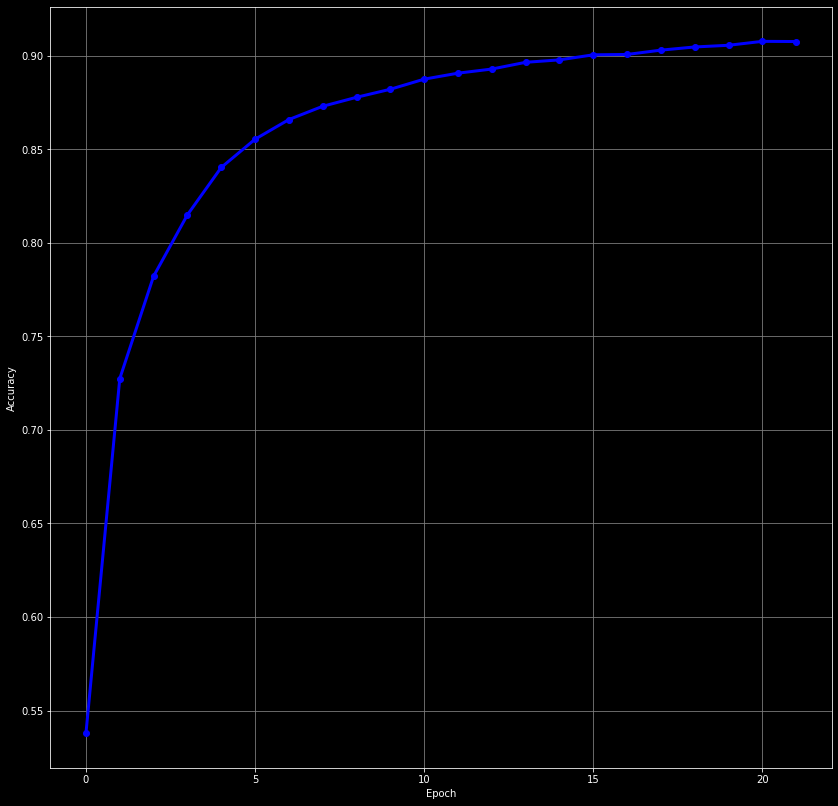

In [46]:
plt.style.use('dark_background')
plt.figure(figsize=(14,14))
plt.plot(range(len(best_Structure.cost_tracker)),best_Structure.cost_tracker,'b-o',linewidth=3)
plt.grid(True,color='grey')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.style.use('dark_background')
# plt.plot([0,nettest.i],[nettest.cost_tracker[-1],nettest.cost_tracker[-1]],'b--')
plt.show()

# MNIST Code Along with CNN

* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note CNN expects 2-dimensional data.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix



# Creat batches for TensorFlow 
Note the method down converts the arr to tensor but we will not be using it down as an error has occurs and we will revert to Torch vision lib to get the data

In [ ]:
def Tensor_small_batches(data, batch_size=10,shape = (1), normalize = None):
  
  if normalize:
    n = len(data)

    temp = [ arr.reshape(shape)/np.max(arr) for arr in  data]
    temp2 = [ arr for arr in  data]
    mini_batches = [
                    temp[k:k+ batch_size]
                    for k in range(0, n, batch_size)]

  else:
    n = len(data)

    temp = [ arr.reshape(shape) for arr in  data]
    temp2 = [ arr for arr in  data]
    mini_batches = [
                    temp[k:k+ batch_size]
                    for k in range(0, n, batch_size)]

  

  return torch.tensor(mini_batches)

xTensor_mini_batches = Tensor_small_batches(train_X,10,(1,28,28),normalize =True)

yTensor_mini_batches = Tensor_small_batches(train_y,10 ,train_y[0].shape )

In [4]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# convolution output is passed into the fully connected layers

In [10]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
  
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:


epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches   train_loader):#
    for b, (X_train, y_train) in enumerate( train_loader):#zip(xTensor_mini_batches,yTensor_mini_batches)):
        b+=1
        # print(y_train.shape)
        # print(y_train[0])
        # print(X_train.shape)
        # print(X_train[0])
        # # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

epoch:  0  batch:  600 [  6000/60000]  loss: 0.00001137  accuracy:  99.600%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.19689891  accuracy:  99.400%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00002974  accuracy:  99.411%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00039813  accuracy:  99.338%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00169559  accuracy:  99.300%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00662870  accuracy:  99.258%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00002471  accuracy:  99.233%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00000826  accuracy:  99.221%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00001693  accuracy:  99.220%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00011472  accuracy:  99.230%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00124071  accuracy:  99.267%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00000186  accuracy:  99.367%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00006398  accuracy:  99.378%
epoch:  1  b

# CNN
## confusion matrix

Test accuracy: 9883/10000 =  98.830%



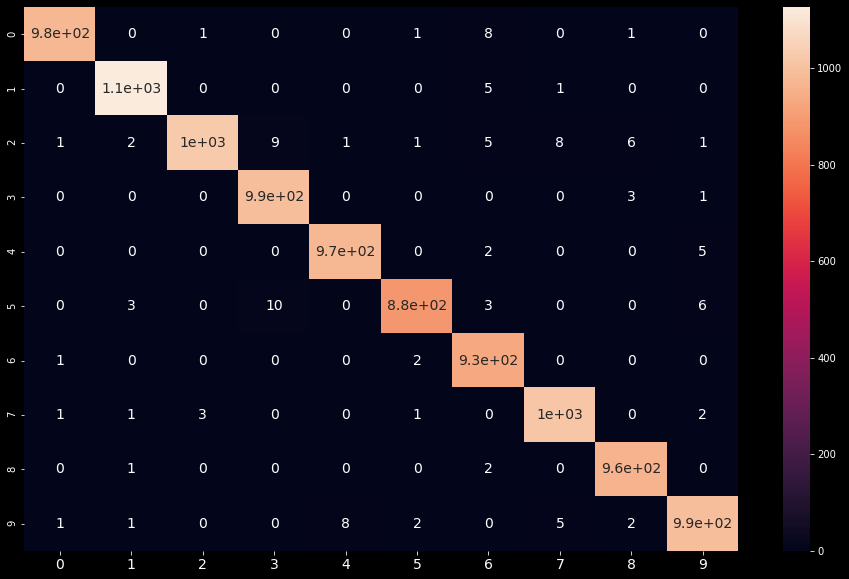

In [54]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
correct = 0
for X_test, y_test in test_load_all:
    y_val = model(X_test)  # we don't flatten the data this time
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
# print(np.arange(10).reshape(1,10))
print()
# print(predicted.view(-1))
# print the confusion matrix

plt.style.use('dark_background')
plt.figure(figsize=(16,10))
plt.xticks(fontsize=14,ticks=range(9,-1,-1),labels=['3','p','3','p','3','p','3','p','3','p'])
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

sns.heatmap(confusion_matrix(predicted.view(-1), y_test.view(-1)),  annot=True, annot_kws={"size": 14})
# plt.xticks(fontsize=14,ticks=range(9,-1,-1),labels=['3','p','3','p','3','p','3','p','3','p'])
# plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Let us have fun and print the percision and recall for each classfication 

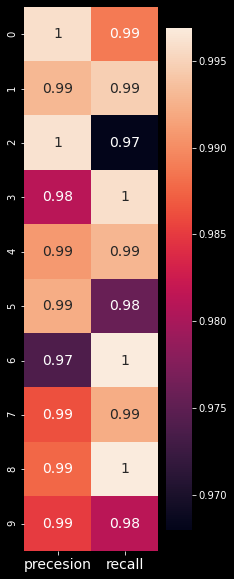

In [55]:
def precision_recall(mat):
  precision_colsum = [ sum(col) for col in mat.T]
  precall_rawsum = [ sum(raw) for raw in mat]
  precesion = []
  recall =[]
  for j in range(len(mat)):
    precesion.append(mat[j,j] / precision_colsum[j])
    recall.append(mat[j,j] / precall_rawsum[j])
  plt.style.use('dark_background')
  plt.figure(figsize=(3,10))
  import pandas
  df = pandas.DataFrame(np.c_[precesion,recall],columns= ['precesion','recall'])
  plt.xticks(fontsize=14)
  sns.heatmap(df,  annot=True, annot_kws={"size": 14})
  # plt.xticks(fontsize=14,ticks=range(9,-1,-1),labels=['3','p','3','p','3','p','3','p','3','p'])
  # plt.yticks(fontsize=14)

  plt.xticks(fontsize=14)
  plt.show()




precision_recall(confusion_matrix(predicted.view(-1), y_test.view(-1)))



# **Very impressive results some number has 100% percision and other has 100% recall**

#ANN
## Let us add a method to print the confusion matrix with self made method we will add the method to the created object
We will import seaborn lib to help visulize the result

In [52]:
from rutaul import pb , pg , pr , py
import seaborn as sns
import pdb


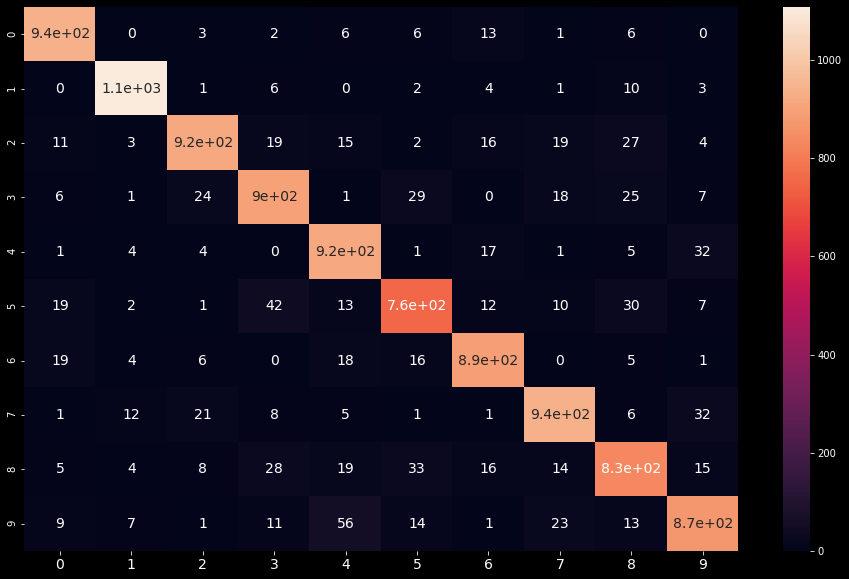

In [53]:

def confusion_matrix_method(self,test_data):

  test_results = [(self.forward(x), y) for (x, y) in test_data]
  # pdb.set_trace(test_results[0][0])
  l = len(test_results[0][0])
  conf_mat = np.zeros((l,l))

  # np.argmax(x)
  for x, y in test_results:
    col = int(np.argmax(x)) 
    conf_mat[y][col] +=1
  plt.style.use('dark_background')
  plt.figure(figsize=(16,10))
  plt.xticks(fontsize=14,ticks=range(9,-1,-1),labels=['3','p','3','p','3','p','3','p','3','p'])
  np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

  sns.heatmap(conf_mat.astype(int),  annot=True, annot_kws={"size": 14})
  # plt.xticks(fontsize=14,ticks=range(9,-1,-1),labels=['3','p','3','p','3','p','3','p','3','p'])
  # plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)
  plt.show()

  return conf_mat.astype(int)



best_Structure.confusion_matrix_cal  = confusion_matrix_method
best_Structure.confusion_matrix  = best_Structure.confusion_matrix_cal(best_Structure,zip(test_Xv,test_y))
# xticklabels=[]

## Printing ANN the percision and recall for each [link text](https://)classfication 


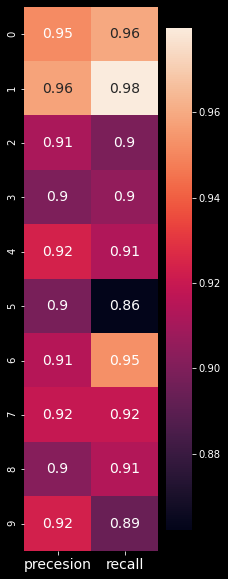

In [ ]:

precision_recall(best_Structure.confusion_matrix)


